### Library Imports

In [1]:
from autoencoder import *
from dataloader import *

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import os

In [2]:
import matplotlib.pyplot as plt

def showTensorInNotebook(tensor):
    """
    This takes a (3, H, W) tensor in R[0.0, 1.0] and displays it with matplotlib.
    """
    image = tensor.detach().numpy().transpose(1,2,0) # move the channel to the end, because PIL and matplotlib hate each other
    plt.imshow(image)
    plt.axis('off')
    plt.show()

This is an initial test, checking whether an autoencoder is reasonably trainable here.

I'm going to train these autoencoders as denoisers, to hopefully make the embedded space more robust.

Thus, we need a noiser.

In [3]:
# This just processes the images.
H, W = 200, 200
processor = v2.Compose([
    v2.PILToTensor(), # the LeafsnapDataset class gives PIL Images, convert to torch Tensor
    v2.Resize((H, W)), # resize
    lambda x: x / 255.0, # convert N[0, 255] to R[0.0, 1.0]
    lambda x: x.reshape(-1) # flatten
])

# This adds the noise for training.
NOISE_RATIO = 0.1
noiser = v2.Compose([
    lambda x: torch.clip(x + NOISE_RATIO*torch.randn_like(x), 0.0, 1.0) # add the noise
])

Then, we can create the dataloader.

In [4]:
root_directory = os.path.join(os.getcwd(), 'leafsnap-dataset')
image_paths_file = os.path.join(root_directory, "leafsnap-dataset-images.txt")
dataset = LeafsnapDataset(image_paths_file, root_directory, use_segmented=False, source="field", transform=processor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Finally, we can make and train the autoencoder.

In [5]:
simple_model = NaiveAutoencoder(3 * H * W, noiser)

train_AE_model(simple_model, dataloader, 10, 1e-3)

Epoch [1/10], Last Loss: 0.0213
Epoch [2/10], Last Loss: 0.0342
Epoch [3/10], Last Loss: 0.0151
Epoch [4/10], Last Loss: 0.0098
Epoch [5/10], Last Loss: 0.0171
Epoch [6/10], Last Loss: 0.0058
Epoch [7/10], Last Loss: 0.0065
Epoch [8/10], Last Loss: 0.0101
Epoch [9/10], Last Loss: 0.0104
Epoch [10/10], Last Loss: 0.0091


Now, a test run of the reconstruction

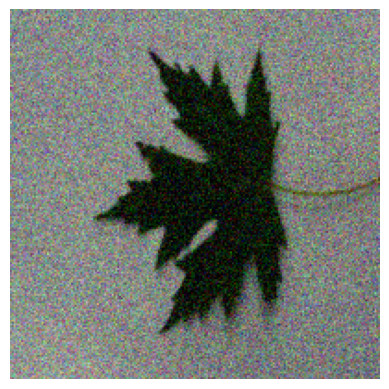

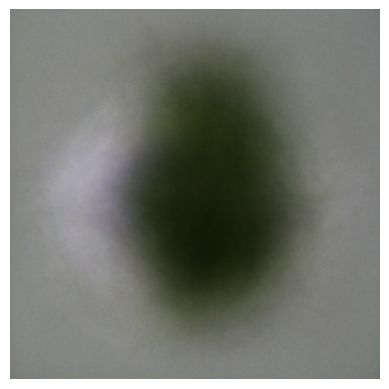

In [7]:
vector = noiser(dataset.__getitem__(400)[0])
image = torch.reshape(vector, (3, H, W))
showTensorInNotebook(image)
reconstructed_vector = simple_model.forward(vector)
reconstructed_image = torch.reshape(reconstructed_vector, (3, H, W))
showTensorInNotebook(reconstructed_image)

Don't work no good. This is definitely an architectural issue. Got some work to do.